In [7]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np

# local .json file with local path info
ungulates_root = os.path.dirname(os.getcwd())
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

import koger_general_functions as kgf
import mapping_functions as kmap

plt.style.use('dark_background')

### Compare difference between locations projected into map from same frame but two different camera matrices (last anchor plus local movement estimation to next anchor vs next anchor)

In [2]:
# keep as '*' to get all observations, or change to specific observation name 
observation_name = "observation088"
tracks_name = "tracks-complete.npy"

kenya_drones_path = local_paths['server']
map_folder = os.path.join(local_paths['pix4d_folder'], observation_name)
# path to the saved flight logs that contain both drone sensor info and the video frame info
flight_logs_folder = os.path.join(map_folder, 'drone-logs')

tracks_file = os.path.join(local_paths["processed_folder"], observation_name, 
                           "localizations", tracks_name) 
frame_folders_root = os.path.join(local_paths['base_frames_folder'], observation_name)

drone_movement_folder = os.path.join(frame_folders_root, 
                                    "worked_examples_drone_movement")

In [4]:
pix4d_info = kmap.get_pix4d_info(map_folder, f"worked_examples_{observation_name}")

In [5]:
tracks = np.load(tracks_file, allow_pickle=True)
# Sometimes images that the flight log suggests to use in map are not actually
# These need to be removed and accounted for
flight_logs = kmap.get_cleaned_flight_logs(flight_logs_folder, 
                                           pix4d_info['pmatrices'])
groundtruth_obs_indexes, _ = kmap.get_groundtruth_obs_indexes(flight_logs, 
                                                              frame_folders_root)

segment_movement_files = glob.glob(
    os.path.join(drone_movement_folder,"drone_movement_segment_*.npy"))
segment_movements = [np.load(file) for file in sorted(segment_movement_files)]

segment_inlier_files = glob.glob(
    os.path.join(drone_movement_folder,"inliers_segment_*.npy"))
segment_inliers = [np.load(file) for file in sorted(segment_inlier_files)]

2 gt images not used in final map.
gt not found. using APR08_2018_A_DJI_0008_08224.jpg for APR08_2018_A_DJI_0008_08226.jpg.


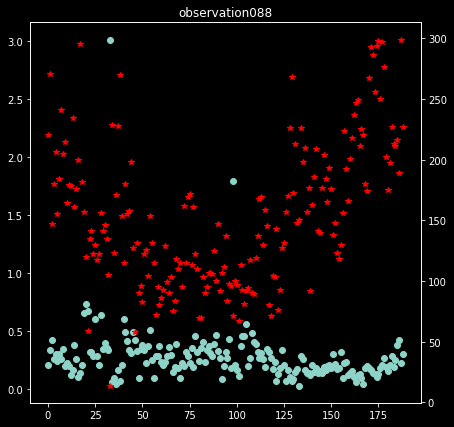

In [6]:
# (meters) consider points on ray within .1 meters of ground to be "on ground"
correct_threshold = 0.5
# max guesses to search for point on ray within correct_threshold of the ground
max_guesses = 50 
# Where to start searching along the ray
mu_est = 80
frame_shape = kmap.get_ungulates_frame_shape(supress_warning=False)

segment_errors = []

for gt_ind, gt_obs_ind in enumerate(groundtruth_obs_indexes[1:]):
    segment_errors.append(
        kmap.calculate_total_segment_error(tracks, gt_obs_ind, gt_ind, 
                                           pix4d_info['pmatrices'], 
                                           segment_movements,
                                           mu_est, pix4d_info['offset'], 
                                           pix4d_info['elevation_r'], 
                                           max_guesses, correct_threshold, 
                                           pix4d_info['pixel_width'], 
                                           pix4d_info['pixel_height'],
                                           pix4d_info['x_origin'], 
                                           pix4d_info['y_origin'], 
                                           frame_shape,
                                           object_height=1
                                          )
    )



distances = [np.linalg.norm(e, axis=1) for e in segment_errors]
mean_distances = [np.nanmax(d) for d in distances]

min_inliers = [np.min(i) for i in segment_inliers]

plt.figure(figsize=(7, 7))
plt.plot(mean_distances, 'o')
plt.title(observation_name)
ax2 = plt.gca().twinx()
ax2.plot(min_inliers, 'r*')